# Q1: Own Calibration

## 1. For the given image calib-object.jpg, identify the chessboard internal corners. You may use external libraries to detect the chessboard corners. 
Note, each square of the chess board is 2cm × 2cm.

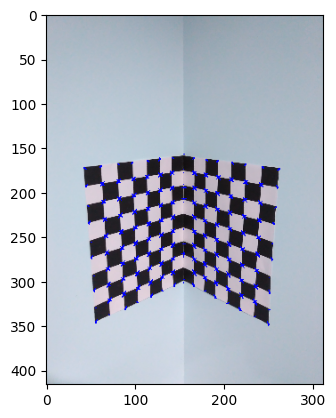

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('calib-object.jpg')
image = cv2.resize(image, [312, 416])
# As actual image size was 3120, 4160

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect corners using Harris Corner Detection
harris_corners = cv2.cornerHarris(gray, 2, 5, 0.04)

# Threshold to find the corners
threshold = 0.001 * harris_corners.max()
corner_image = np.zeros_like(gray)
image_copy = image.copy()
image_copy[harris_corners > threshold] = [0,0,255]

plt.imshow(image_copy)


*"cornerHarris"* function is used to detect corner. The parameters are:

* img - Input image. It should be grayscale and float32 type.* 
blockSize - It is the size of neighbourhood considered for corner detectio.
* 
ksize - Aperture parameter of the Sobel derivate used.    
* .
k - Harris detector free parameter in the equatio

The corners are marked in 'blue' color. n.

## 2.  Implement the camera calibration process discussed in the lecture. Assume a world origin, create a set of corresponding points in the world coordinate and image plane, compute both extrinsics (translation vector, rotation matrix) and intrinsics (assume no skew) without using any external libraries for the calib-object.jpg image.


I am asssuming the world origin at the mid-point of the edge shared by two chessboards. 

The set of corresponding points in the world coordinate and image plane used is:

| World Coordinates| Image Coordinates | 
|-----|-----|
| (-0.14,0.09,0) | (43,173) | 
| (-0.14,-0.09,0) | (56,344) |
| (0,-0.09,0.14) | (250,350) |
| (0,0.14,0.09) | (262,175) |
| (0,-0.09,0) | (155,300) |
| (0,0.09,0) | (155,160) |
| (-0.14,0.01,0) | (49,257) |
| (0,0.01,0.14) | (255,259) |3 |


This can be found manually by hovering over the marked corners.

I created a class and defined all the function in it, to do all the steps of calliberation. 

In [2]:
class camera_calliberation():
    def __init__(self, world_coordinates, camera_coordinates):
        self.P = np.zeros((3, 4))     # Projection Matrix
        self.K = np.zeros((3, 3))     # Calliberation Matrix
        self.R = np.zeros((3, 3))     # Rotation Matrix
        self.C = np.zeros((3, 1))     # Camera Coordinates wrt World 
        self.T = np.zeros((3, 1))     # Translation Vector
        
        self.M_intrinsics = np.zeros((3, 4))     # Intrinsic Matrix
        self.M_extrinsics = np.zeros((4, 4))     # Extrinsic Matrix

        self.world_coordinates = world_coordinates
        self.camera_coordinates = camera_coordinates

    def find_projection_matrix(self): # Method 1
        A = np.dot(np.transpose(self.world_coordinates), np.linalg.pinv(np.transpose(self.world_coordinates)))
        self.P = np.dot(np.transpose(self.camera_coordinates), np.linalg.pinv(np.transpose(self.world_coordinates)))
        self.P = np.dot(self.P, np.linalg.inv(A))
        return
        
    def find_projection_matrix_only(self): # Method2
        A = []
        for i in range(len(camera_coordinates)):
            x, y, z, w = self.world_coordinates[i]
            u, v, d = self.camera_coordinates[i]
            A.append([x, y, z, 1, 0, 0, 0, 0, -u * x, -u * y, -u * z, -u])
            A.append([0, 0, 0, 0, x, y, z, 1, -v * x, -v * y, -v * z, -v])
    
        A = np.array(A)
        print(A)
        _, _, V = np.linalg.svd(A)
        P = V[-1, :].reshape(3, 4)
        self.P = P
        return P
        
    def extract_calibration_matrix_only(P): #Another way to find calliberation matrix
        M = P[:, :3] 
        # QR decomposition
        K, R = np.linalg.qr(np.linalg.inv(M))  
        K = np.linalg.inv(K) 
        return K
        
    def compute_matrices(self):
        M = self.P[:, :3] 
        MMT = np.dot(M, M.T) 
        
        # CALLIBERATION MATRIX, K
        # Skew of Calliberation matrix is 0. 
        
        self.K[0][2] = MMT[0][2]
        self.K[1][2] = MMT[1][2]
        self.K[1][1] = (MMT[1][1]-MMT[1][2]**2)*(1/2)
        self.K[0][0] = (MMT[0][0]-MMT[0][2]**2)*(1/2)
        self.K[2][2] = 1

        # ROTATION MATRIX
        self.R = np.dot(np.linalg.inv(self.K), M)

        # CAMERA CENTRE
        p4 = self.P[:, 3]     # 4th Column
        self.C = np.dot(-np.linalg.inv(M), p4)

        # TRANSLATION VECTOR
        self.T = np.dot(np.linalg.inv(self.K), p4)
        
        # INTRINSICS MATRIX
        for i in range(0,3):
            for j in range(0,3):
                self.M_intrinsics[i][j]=self.K[i][j]

        # EXTRINSICS MATRIX
        for i in range(0,3):
            for j in range(0,3):
                self.M_extrinsics[i][j]=self.R[i][j]
        
        for i in range(0,3):
            self.M_extrinsics[i][3] = self.T[i]

        self.M_extrinsics[3][3] = 1
        
        return 
        
    def world_to_image(self, world_points):
        return np.transpose(np.dot(self.P, np.transpose(world_points)))

    def draw_wireframe(self, image, points):
        for point in points:
            cv2.circle(image, point, 5, (0, 0, 255), -1) 
            
        for i in range(len(points)):
            start_point = tuple(points[i])
            end_point = tuple(points[(i + 1) % len(points)])
            cv2.line(image, start_point, end_point, (255, 0, 0), 2) 

        return image


world_coordinates =np.array([[-0.14, 0.09, 0, 1], [-0.14, -0.09, 0, 1], [-0.08, 0.09, 0, 1], [-0.08, -0.09, 0, 1], [0, 0.09, 0.08, 1], [0, -0.09, 0.08, 1], [0, 0.09, 0.14, 1], [0, -0.09, 0.14, 1]])
camera_coordinates=np.array([[43, 173, 1],[56, 346, 1],[97, 166, 1],[104, 324, 1], [210, 167, 1],[205, 325, 1], [263, 175, 1],[250, 349, 1]])

calliberation = camera_calliberation(world_coordinates, camera_coordinates)
calliberation.find_projection_matrix()
calliberation.compute_matrices()

print("Camera Centre:", calliberation.C)

print("===================================================================")
print("\n")

print("Calliberation Matrix:", calliberation.K)
print("Intrinsic Matrix:", calliberation.M_intrinsics)

print("===================================================================")
print("\n")

print("Rotation Matrix:", calliberation.R)
print("\n")
print("Translation Vector:", calliberation.T)
print("\n")
print("Extrinsics Matrix:", calliberation.M_extrinsics)
print("\n")
print("Projection Matrix", calliberation.P)

Camera Centre: [-2.45395191e+44  1.38928499e+44  2.57540777e+44]


Calliberation Matrix: [[ 5.21454565e+05  0.00000000e+00  8.56842641e-43]
 [ 0.00000000e+00  4.88636089e+05 -9.73543827e-43]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Intrinsic Matrix: [[ 5.21454565e+05  0.00000000e+00  8.56842641e-43  0.00000000e+00]
 [ 0.00000000e+00  4.88636089e+05 -9.73543827e-43  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]


Rotation Matrix: [[ 1.41640287e-03 -5.32697950e-06  1.35247912e-03]
 [-5.03232245e-04 -1.88449719e-03  5.37078418e-04]
 [ 2.53985347e-45 -3.28429328e-47 -1.44508904e-45]]


Translation Vector: [2.97884694e-04 4.60806461e-04 1.00000000e+00]


Extrinsics Matrix: [[ 1.41640287e-03 -5.32697950e-06  1.35247912e-03  2.97884694e-04]
 [-5.03232245e-04 -1.88449719e-03  5.37078418e-04  4.60806461e-04]
 [ 2.53985347e-45 -3.28429328e-47 -1.44508904e-45  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Pro

[[ 51.68076923 176.71730769   1.        ]
 [ 52.18076923 342.46730769   1.        ]
 [ 95.99615385 161.96346154   1.        ]
 [ 96.49615385 327.71346154   1.        ]
 [211.50384615 163.28653846   1.        ]
 [212.00384615 329.03653846   1.        ]
 [253.81923077 179.03269231   1.        ]
 [254.31923077 344.78269231   1.        ]]
[(51, 176), (52, 342), (95, 161), (96, 327), (211, 163), (212, 329), (253, 179), (254, 344)]


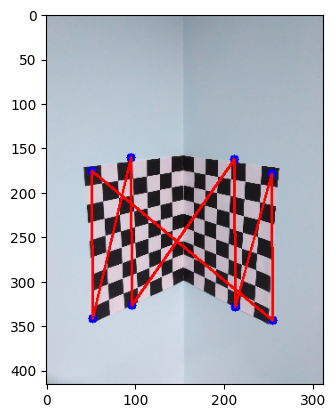

In [3]:
# Plotting the recontructed points for verification

image_points = calliberation.world_to_image(world_coordinates)
print(image_points)

# Converting points to appropriate type to use cv2.line and cv2.circle
points = []
for i in range(image_points.shape[0]):
    point = (int(image_points[i][0]), int(image_points[i][1]))
    points.append(point)
print(points)

wireframe_image = calliberation.draw_wireframe(image.copy(), points)
plt.imshow(wireframe_image)


## 3.  Use the real-world measurements along with the estimated camera parameters to compute the image of a wireframe of the object

The wireframe is the outer corners of the actual chessboard pattern and has 6 points

In [4]:
wireframe_world_coordinates =np.array([[-0.14, 0.09, 0, 1], [-0.14, -0.09, 0, 1], [0, 0.09, 0.14, 1], [0, -0.09, 0.14, 1], [0, 0.09, 0, 1], [0, -0.09, 0, 1]])
wireframe_camera_coordinates=np.array([[43, 173, 1],[56, 346, 1], [263, 175, 1],[250, 349, 1], [150, 173, 1], [150, 348, 1]])

 Note that you should compute the location of image points as $x_i = P X_i$, where $P$ is the projection matrix computed above.

In [5]:
wireframe_image_points = calliberation.world_to_image(wireframe_world_coordinates)
print(wireframe_image_points)

[[ 51.68076923 176.71730769   1.        ]
 [ 52.18076923 342.46730769   1.        ]
 [253.81923077 179.03269231   1.        ]
 [254.31923077 344.78269231   1.        ]
 [155.08333333 142.29166667   1.        ]
 [155.58333333 308.04166667   1.        ]]


Overlay (draw) the wireframe over the actual image of the object using straight lines between the computed points $x_i$.

[(51, 176), (52, 342), (253, 179), (254, 344), (155, 142), (155, 308)]


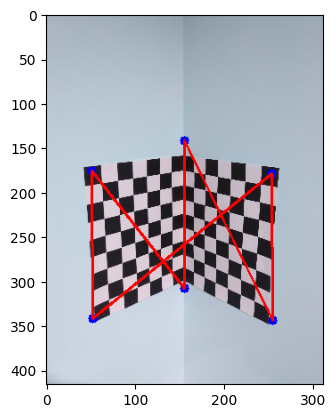

In [6]:
# Converting points to appropriate type to use cv2.line and cv2.circle
points = []
for i in range(wireframe_image_points.shape[0]):
    point = (int(wireframe_image_points[i][0]), int(wireframe_image_points[i][1]))
    points.append(point)
print(points)

wireframe_image = calliberation.draw_wireframe(image.copy(), points)
plt.imshow(wireframe_image)


What do you observe about the overlay?

We were able to reconstruct the 6 points, but they were bit distorted. So, we can say that we weren't precise in calliberating the matrix. 

## 4. Given the rotation matrix, compute the three rotation angles. Explain the values that you obtain in terms of pan, tilt, and roll?

|  cos(alpha) * cos(beta)                           | cos(alpha)*sin(beta)*sin(gamma)-sin(alpha)cos(gamma)                          |  cos(alpha)*sin(beta)*cos(gamma)+sin(alpha)sin(gamma)         |
|---------------------------------------------------|---------------------------------------------------|---------------------|
|  sin(alpha) * cos(beta) | sin(alpha)*sin(beta)*sin(gamma)-cos(alpha)cos(gamma)   | sin(alpha)*sin(beta)*cos(gamma)-cos(alpha)sin(gamma)   |
|  -sin(beta)| cos(beta) * sin(gamma)  |  cos(beta) * cos(beta) |


The alpha, beta and gamma are the angle made between the previos and rotated axis along X, Y and Z axes respectively. 

We can use one-one correspondance to solve the values for alpha, beta and gamma. 

In [7]:
print(calliberation.R)

beta = -np.arcsin(calliberation.R[2][0])

gamma = np.arcsin(calliberation.R[2][1] / np.cos(beta))

alpha = np.arcsin(calliberation.R[1][0] / np.cos(beta))

print("\n")
print("Alpha (Pan): ", alpha)
print("Beta (Tilt)", beta)
print("Gamma(Roll)", gamma)

[[ 1.41640287e-03 -5.32697950e-06  1.35247912e-03]
 [-5.03232245e-04 -1.88449719e-03  5.37078418e-04]
 [ 2.53985347e-45 -3.28429328e-47 -1.44508904e-45]]


Alpha (Pan):  -0.0005032322664202871
Beta (Tilt) -2.539853466588731e-45
Gamma(Roll) -3.28429327576129e-47


**Pan:** Rotation of an object or camera around its vertical axis, which is typically aligned with the y-axis in a standard coordinate system.


**Tilt:** Rotation of an object or camera around its horizontal axis, which is typically aligned with the x-axis in a standard coordinate system. 


**Roll:** Rotation of an object or camera around its longitudinal axis, which is typically aligned with the z-axis in a standard coordinate system. ans.

# Q2: OpenCV Calibration

## 1. Now repeat the camera calibration process for calib-object.jpg using OpenCV calibration functions, continue to assume that there is no skew or distortion.

In [48]:
world_points = np.array([[-0.14, 0.09, 0], [-0.14, -0.09, 0], [-0.08, 0.09, 0], [-0.08, -0.09, 0], [0, 0.09, 0.08], [0, -0.09, 0.08], [0, 0.09, 0.14], [0, -0.09, 0.14]], np.float32)
image_points = np.array([[43, 173],[56, 346],[97, 166],[104, 324], [210, 167],[205, 325], [263, 175],[250, 349]], np.float32)

K = np.array([[2.68154282e+01, 0.00000000e+00, 4.66490146e-13],
    [0.00000000e+00, 9.70561990e+02, 1.05116635e-13],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera([world_points], [image_points], (image.shape[1], image.shape[0]),K,None, flags = cv2.CALIB_USE_INTRINSIC_GUESS)
print("New Camera Matrix: \n", cameraMatrix)

New Camera Matrix 
 [[ 34.96378303   0.         128.67851534]
 [  0.         693.17666858  49.11170139]
 [  0.           0.           1.        ]]


How does your result compare with Q1 above?

The *cv2.CALIB_USE_INTRINSIC_GUESS* function takes as input an estimated matrix of the camera along with Object points, Image Points and image size and return and refines the provided estimate. 

**Without cv2.CALIB_USE_INTRINSIC_GUESS:** In this case, the calibration algorithm starts with an initial guess for the camera matrix. It then iteratively adjusts the parameters of the camera matrix and distortion coefficients to minimize the reprojection error (the difference between the observed image points and the projected points). The algorithm estimates the camera matrix and distortion coefficients solely based on the provided image points and object points.



**With cv2.CALIB_USE_INTRINSIC_GUESS:** When you use this flag along with providing the actual existing estimated matrix, the calibration algorithm starts with this provided initial guess,then refines it by optimizing the parameters based on the observed image points and object points. It fine-tunes the estimated matrix rather than starting from scratch. This can lead to faster convergence and potentially more accurate results.s.

We can observe that the results are better when we use *cv2.CALIB_USE_INTRINSIC_GUESS*. This fine tunes the provided estimated matrix to provide better results. 

## 2. Repeat Q2.1, for the second image assign1.jpg. Does the wireframe overlay show significant distortions?

**Using self defined function:**

Camera Centre: [ 4.69836094e+29 -3.69615909e+31  2.35513979e+31]


Calliberation Matrix: [[1.24853438e+05 0.00000000e+00 3.75060360e-30]
 [0.00000000e+00 5.40524513e+04 7.21020934e-29]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Intrinsic Matrix: [[1.24853438e+05 0.00000000e+00 3.75060360e-30 0.00000000e+00]
 [0.00000000e+00 5.40524513e+04 7.21020934e-29 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]


Rotation Matrix: [[ 3.99992290e-03 -3.50464279e-05 -1.34797938e-04]
 [ 8.14458514e-05 -3.26770628e-03 -5.12996680e-03]
 [-7.88230386e-46 -9.86076132e-32 -1.97215226e-31]]


Translation Vector: [8.62823110e-04 1.68035132e-03 1.00000000e+00]


Extrinsics Matrix: [[ 3.99992290e-03 -3.50464279e-05 -1.34797938e-04  8.62823110e-04]
 [ 8.14458514e-05 -3.26770628e-03 -5.12996680e-03  1.68035132e-03]
 [-7.88230386e-46 -9.86076132e-32 -1.97215226e-31  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Projection Matrix [[ 4.9

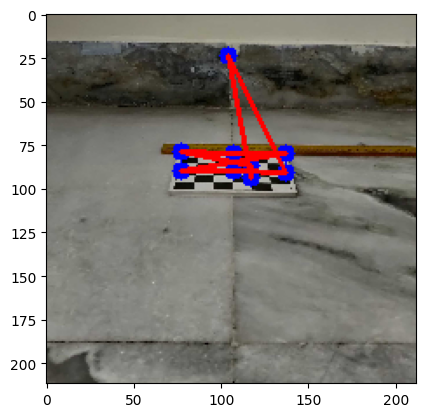

In [99]:
image2 = cv2.imread('assign1.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2 = cv2.resize(image2, [212, 212])
# plt.axis('off')
plt.imshow(image2)

world_coordinates = np.array([[0, 0.2, 0.11, 1], [0.02, -0.02, 0, 1], [0.02, 0.02, 0, 1], [-0.06, 0.06, 0, 1], [0, 0.06, 0, 1], [0.06, 0.06, 0, 1], [-0.06, 0, 0, 1], [0, 0, 0, 1], [0.06, 0, 0, 1]])
camera_coordinates=np.array([[105, 25, 1],[120, 95, 1],[118, 90, 1], [81, 80, 1],[107, 80, 1],[135, 80, 1],[75, 90, 1],[105, 90, 1],[140, 90, 1]])

calliberation = camera_calliberation(world_coordinates, camera_coordinates)
calliberation.find_projection_matrix()
calliberation.compute_matrices()

print("Camera Centre:", calliberation.C)

print("===================================================================")
print("\n")

print("Calliberation Matrix:", calliberation.K)
print("Intrinsic Matrix:", calliberation.M_intrinsics)

print("===================================================================")
print("\n")

print("Rotation Matrix:", calliberation.R)
print("\n")
print("Translation Vector:", calliberation.T)
print("\n")
print("Extrinsics Matrix:", calliberation.M_extrinsics)
print("\n")
print("Projection Matrix", calliberation.P)

image_points = np.transpose(np.dot(calliberation.P, np.transpose(world_coordinates)))
print(image_points)

# Converting points to appropriate type to use cv2.line and cv2.circle
points = []
for i in range(image_points.shape[0]):
    point = (int(image_points[i][0]), int(image_points[i][1]))
    points.append(point)
print(points)

wireframe_image = calliberation.draw_wireframe(image2.copy(), points)
plt.imshow(wireframe_image)


world_coordinates = np.array([[0, 0.2, 0.11], [0.02, -0.02, 0], [0.02, 0.02, 0], [-0.06, 0.06, 0], [0, 0.06, 0], [0.06, 0.06, 0], [-0.06, 0, 0], [0, 0, 0], [0.06, 0, 0]], dtype=np.float32)
camera_coordinates=np.array([[105, 25],[120, 95],[118, 90], [81, 80,],[107, 80],[135, 80],[75, 90],[105, 90],[140, 90]], dtype=np.float32)

ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera([world_coordinates], [camera_coordinates], (image.shape[1], image.shape[0]),calliberation.K,None, flags = cv2.CALIB_USE_INTRINSIC_GUESS)

print("===================================================================")
print("\n")
print("New Camera Matrix: \n", cameraMatrix)


The distortion has now become very less comparitively. 

What can we say about the computed projection matrix when trying to do calibration based on world coordinate points that are co-planar? 

**Multiple solutions:** When the world coordinate points used for calibration are co-planar it may result in multiple possible solutions, or the computed projection matrix may be highly sensitive to small changes in the input data.

**Lack of depth information:** Co-planar points provide limited depth information to the calibration process. This can result in ambiguities in estimating the camera's intrinsic parameters (such as focal length and principal point) and extrinsic parameters (such as rotation and translation). Without sufficient depth variation in the calibration data, the calibration algorithm may struggle to accurately determine the camera's parameters.

**Errors in calibration:** Calibration based on co-planar points may lead to inaccurate calibration results. The computed projection matrix may not accurately represent the mapping between world coordinates and image coordinates, leading to errors in 3D reconstruction.


##  3. What is the image of the world origin, given the calibration matrix? Does this result agree with your observations?

In [98]:
origin_point = np.array([[0,0,0,1]])
image_origin = np.transpose(np.dot(calliberation.P, np.transpose(origin_point)))
print(image_origin)
print("\n")

[[107.72643187  90.82710779   1.        ]]




We can observe that it is close to our observation. 

# Q3: Moving the Chessboard

##  1. Imagine that the chessboard in assign1.jpg was moved by 10 cm to the right (along the ruler)

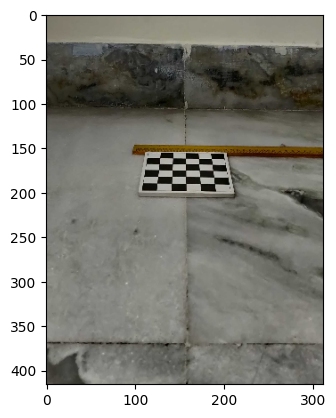

In [111]:
image2 = cv2.imread('assign1.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2 = cv2.resize(image2, [312, 416])
# plt.axis('off')
plt.imshow(image2)

We can find the pixel coordinates of the 4 corners of the chessboard and then find the world coordinates of it. 
Then, we can add 0.10 m to it on the X coordiates. Then, we can find the corresponding pixel coordinates. 

**NOTE:** Assumed the world coordinate centre at the centre of the chessboard. 

In [109]:
world_points = np.array([[0.06, -0.06, 0, 1], [0.06, 0.06, 0, 1], [-0.06, 0.06, 0, 1], [-0.06, -0.06, 0, 1], [0, -0.06, 0, 1], [0, 0.06, 0, 1]])
world_points[:, 0] += 0.1

Overlay a wireframe (4 points) of the virtual chessboard on the image at the appropriate location.

[[187.89363216 102.12913554   1.        ]
 [187.36855212  80.93383138   1.        ]
 [127.44005692  80.40554963   1.        ]
 [127.96513696 101.60085379   1.        ]
 [157.92938456 101.86499466   1.        ]
 [157.40430452  80.6696905    1.        ]]
[(187, 102), (187, 80), (127, 80), (127, 101), (157, 101), (157, 80)]


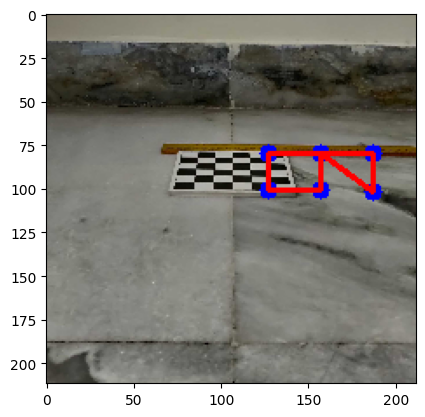

In [110]:
image_points = np.transpose(np.dot(calliberation.P, np.transpose(world_points)))
print(image_points)

# Converting points to appropriate type to use cv2.line and cv2.circle
points = []
for i in range(image_points.shape[0]):
    point = (int(image_points[i][0]), int(image_points[i][1]))
    points.append(point)
print(points)

wireframe_image = calliberation.draw_wireframe(image2.copy(), points)
plt.imshow(wireframe_image)

Does the wireframe look consistent with what you expect?


Yes. We can observe that in the ruler that the shifted wireframe is 10cm to the right of its original position.  

## 2. Now, think of how you would move the actual pixels or pattern of the chessboard?

Overlay the chessboard pattern within the predicted wireframe.

**Step 1:** We can create a bounding box around the chess board. 

**Step 2:** Find the corresponding world coordinates of it. 

**Step 3:** Add 10cm to its X coordinate. 

**Step 4:** Convert the new world coordinates back to its image coordinate and show the new image. 

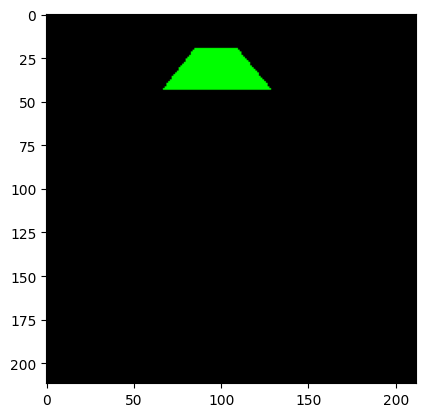

In [128]:
points = np.array([[127, 42], [127, 20], [67, 20], [67, 42]], dtype=np.int32)

rect = cv2.boundingRect(points)
x, y, w, h = rect

# Define the vertices of the trapezium
trapezium_points = np.array([
    [x, y + h],     # Bottom-left corner
    [x + w, y + h], # Bottom-right corner
    [x + 0.7 * w, y], # Top-right corner
    [x + 0.3 * w, y]  # Top-left corner
], dtype=np.int32)

bounding_box_image = np.zeros((212, 212, 3), dtype=np.uint8)  
cv2.fillConvexPoly(bounding_box_image, trapezium_points, (0, 255, 0))  

plt.imshow(bounding_box_image)


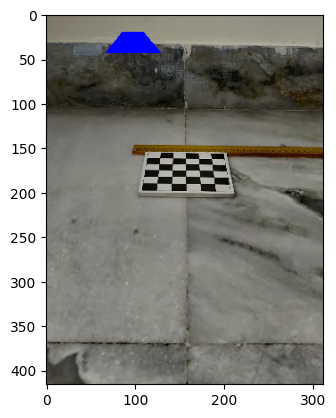

In [134]:
import cv2
import numpy as np

image2 = cv2.imread('assign1.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image = cv2.resize(image2, [312, 416])

points = np.array([[187, 102], [187, 80], [127, 80], [127, 102]], dtype=np.int32)

height, width, _ = image.shape

mask = np.zeros((height, width), dtype=np.uint8)
cv2.fillConvexPoly(mask, trapezium_points, 255)

for i in range(height):
    for j in range(width):
        if mask[i, j] != 0:
            image[i, j] = [0, 0, 255] 

plt.imshow(image)



Is the overlay consistent with what you expect?

Yes, we can observe that it close to what we wanted. 